<a href="https://colab.research.google.com/github/droyktton/ActiveInterface/blob/main/HowToUseActiveInterface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descarga

La última versión siempre estará en github y la descargamos así:

In [ ]:
!rm -rf ActiveInterface; git clone https://github.com/droyktton/ActiveInterface.git

Cloning into 'ActiveInterface'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 372 (delta 30), reused 35 (delta 17), pack-reused 320 (from 2)
Receiving objects: 100% (372/372), 1.91 MiB | 6.00 MiB/s, done.
Resolving deltas: 100% (230/230), done.


# Compilación

Se compila con make. Veamos antes que opciones tiene el Makefile

In [ ]:
!cat ActiveInterface/Makefile

CXX = nvcc

TAU?=1.0
MONITOR?=10000
Dt?=0.1
C2?=1.0
C4?=0.0
C6?=0.0
C12?=0.0
MONITORCONF?=100000
TEMP?=0.1

INCLUDES = -I/opt/nvidia/hpc_sdk/Linux_x86_64/23.7/math_libs/12.2/include 
FLAGS = --expt-extended-lambda -lcufft -std=c++17 -arch=sm_75 \
-gencode arch=compute_61,code=sm_61 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_75,code=sm_75 \
-DNOMONITOR #-DNOLOGMONITOR 
PARAMSEW = -DC2=$(C2) -DTAU=$(TAU) -DMONITOR=$(MONITOR) -DNBINS=100 -DDt=$(Dt) -DMONITORCONF=$(MONITORCONF) -DTEMP=$(TEMP)#-DDOUBLE  
PARAMSKPZ = -DC2=$(C2) -DKPZ=1.0 -DTAU=$(TAU) -DMONITOR=$(MONITOR) -DNBINS=100 -DDt=$(Dt) -DMONITORCONF=$(MONITORCONF) -DTEMP=$(TEMP) #-DDOUBLE  
PARAMSANH = -DC2=$(C2) -DC4=$(C4) -DC6=$(C6) -DTAU=$(TAU) -DMONITOR=$(MONITOR) -DDt=$(Dt) -DMONITORCONF=$(MONITORCONF) -DTEMP=$(TEMP) #-DDOUBLE  
PARAMSPUREANH = -DC12=1.0 -DTAU=$(TAU) -DMONITOR=$(MONITOR) -DDt=$(Dt) -DNBINS=100 -DMONITORCONF=$(MONITORCONF) -DTEMP=$(TEMP) #-DDOUBLE  
PARAMSALM = -DC2=$(C2) -DC4=$(C4) -DC12=$(C12) -D

Hay muchos modos, y en cada uno un set de parametros.
Por ejemplo, compilemos el modo ANH, que define los siguientes parametros

```
PARAMSANH = -DC2=$(C2) -DC4=$(C4) -DC6=$(C6) -DTAU=$(TAU) -DMONITOR=$(MONITOR) -DNBINS=100 -DDt=$(Dt) -DMONITORCONF=$(MONITORCONF) -DTEMP=$(TEMP)
```

y esta pensado para estudiar la elasticidad C2 y C4 y C6 combinadas con un TAU para la correlacion temporal del tiempo. TEMP es la amplitud del ruido colorado.

Los otros parametros miden MONITOR y MONITORCONF dicen cada cuanto se graban las configuraciones completas, la posicion del centro de masa o la rugosidad. Conviene que no sean muy chicos porque ocupan mucho lugar.

Por default se guarda el factor de estructura vs q y t y la rugosidad vs t en t espaciado exponencialmente, es decir linealmente en escala log.

Compilemos un ejemplo mezcla de C2 y C4 y C6, con paso de tiempo Dt y amplitud de ruido TEMP:





In [ ]:
!cd ActiveInterface; make clean; make ANH C2=0.5 C4=0.0 C6=1.0 Dt=0.1 TAU=100 MONITOR=1000000000 MONITORCONF=1000000000 TEMP=1.0

rm -f activeinterface
nvcc --expt-extended-lambda -lcufft -std=c++17 -arch=sm_75 -gencode arch=compute_61,code=sm_61 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_75,code=sm_75 -DNOMONITOR  -DC2=0.5 -DC4=0.0 -DC6=1.0 -DTAU=100 -DMONITOR=1000000000 -DDt=0.1 -DMONITORCONF=1000000000 -DTEMP=1.0  ew.cu -o activeinterface -L/opt/nvidia/hpc_sdk/Linux_x86_64/23.7/math_libs/12.2/lib64  -I/opt/nvidia/hpc_sdk/Linux_x86_64/23.7/math_libs/12.2/include  


Ya tenemos el ejecutable en

```
/content/ActiveInterface/activeinterface
```

# Correr

Vamos a correr 5 semillas. Para eso armamos un script

In [ ]:
%%bash
#!/bin/bash

for i in {1..2}
do
  dir=run_$i
  echo "Running with seed $i in $dir"
  mkdir $dir
  cd $dir
  /content/ActiveInterface/activeinterface 32768 16385 $i
  cd ../
done

Running with seed 1 in run_1
starting warming up noise
noise ready
Time taken: 4.48038 seconds
 L=32768 Nrun=16385
Running with seed 2 in run_2
starting warming up noise
noise ready
Time taken: 3.84076 seconds
 L=32768 Nrun=16385


mkdir: cannot create directory ‘run_1’: File exists
mkdir: cannot create directory ‘run_2’: File exists


# Promediar los resultados

Empecemos promediando el factor de estructura

In [ ]:
%%bash
#!/bin/bash
bash /content/ActiveInterface/prom_inst_sofq.sh "/content/run_*" > prom_inst_sofq.dat

In [ ]:
!head prom_inst_sofq.dat

#2
0 0
0.38352 0
4.54874 0
1.50388 0
1.43309 0
2.35784 0
2.23436 0
3.04486 0
4.15914 0


# Graficar



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Factor de Estructura


Vamos a graficar el S(q) promediado en las 5 semillas, y ademas suavizar un poco la curva (en realidad habria que promediar mas y suavizar menos).

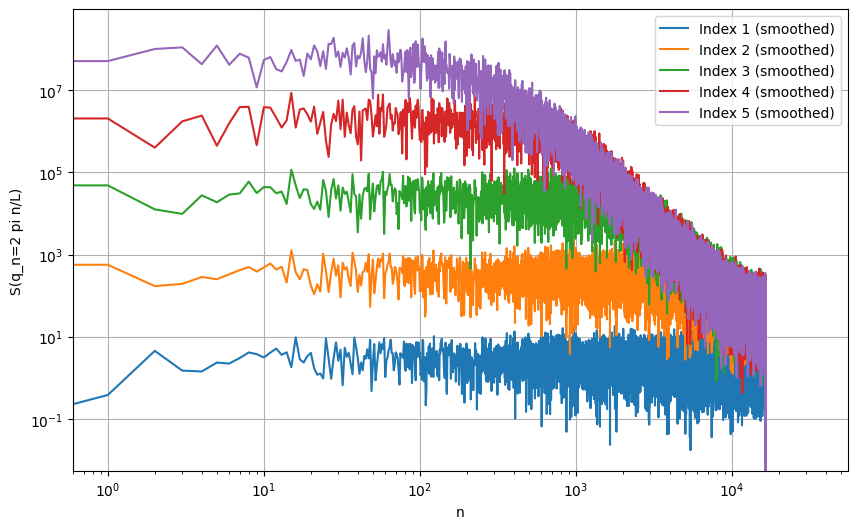

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Import pandas for rolling mean

file_path = '/content/prom_inst_sofq.dat'

with open(file_path, 'r') as f:
    # Skip the first line
    next(f)
    data_blocks = []
    current_block = []
    for line in f:
        if line.strip() == '':
            if current_block:
                data_blocks.append(np.array(current_block))
                current_block = []
        else:
            # Skip lines that start with '#' which might appear after the first line
            if line.strip().startswith('#'):
                continue
            try:
                current_block.append(list(map(float, line.split())))
            except ValueError:
                # Handle potential errors if a line cannot be converted to float
                print(f"Skipping line due to ValueError: {line.strip()}")


    if current_block:
        data_blocks.append(np.array(current_block))

plt.figure(figsize=(10, 6))

# Define window size for smoothing
window_size = 1 # You can adjust this value

# Plot the second column (index 1) for the first 6 data blocks with smoothing
for i in range(min(6, len(data_blocks))):
    if data_blocks[i].shape[1] > 1: # Ensure the block has at least 2 columns
        # Apply rolling mean to the second column
        smoothed_data = pd.Series(data_blocks[i][:, 0]).rolling(window=window_size, center=True).mean()
        # Plot the original x-values against the smoothed y-values
        plt.plot(smoothed_data, label=f'Index {i+1} (smoothed)')
    else:
        print(f"Data block {i+1} does not have a second column to plot.")

plt.xscale('log')
plt.yscale('log')
plt.xlabel('n')
plt.ylabel('S(q_n=2 pi n/L)')
plt.legend()
plt.grid(True)
plt.show()

## Varianza vs t

In [ ]:
import glob

file_pattern = 'run_*/cmlog.dat'
cmlog_files = glob.glob(file_pattern)
print(cmlog_files)

['run_1/cmlog.dat', 'run_2/cmlog.dat']


Veamos las curvas individuales

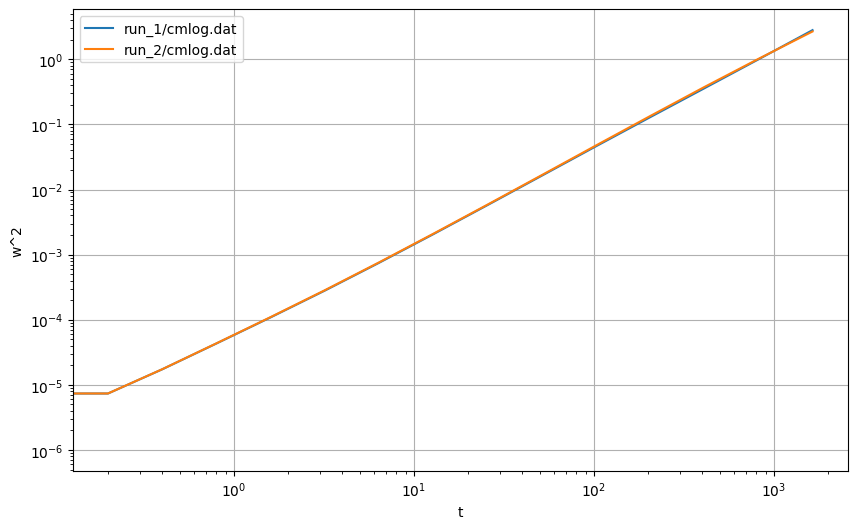

In [ ]:
plt.figure(figsize=(10, 6))

for file_path in cmlog_files:
    try:
        data = np.loadtxt(file_path)
        col1 = data[:, 0]
        col4 = data[:, 3]
        plt.plot(col1, col4, label=file_path)
    except Exception as e:
        print(f"Could not process file {file_path}: {e}")

plt.xscale('log')
plt.yscale('log')
plt.xlabel('t')
plt.ylabel('w^2')
plt.legend()
plt.grid(True)
plt.show()

y ahora el promedio de todas las curvas

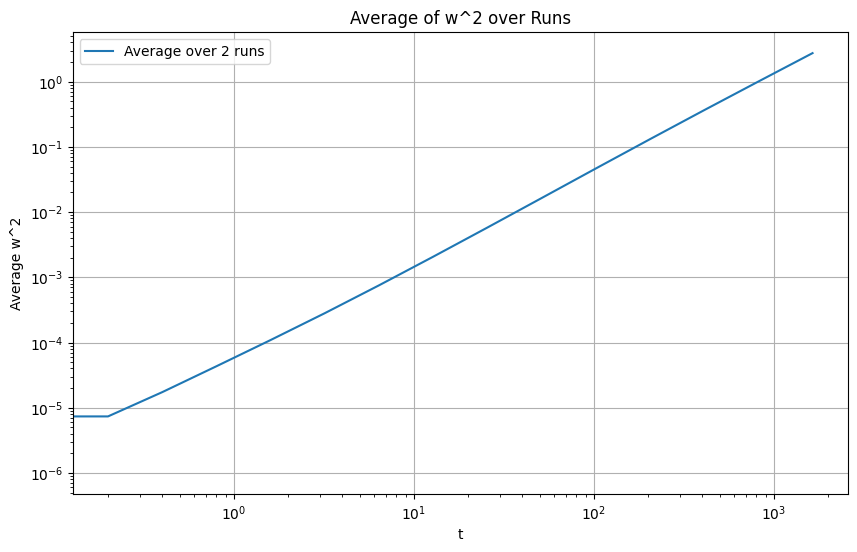

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt

file_pattern = 'run_*/cmlog.dat'
cmlog_files = glob.glob(file_pattern)

if not cmlog_files:
    print("No cmlog.dat files found.")
else:
    # Read the data from the first file to get the shape and column 1
    try:
        data_template = np.loadtxt(cmlog_files[0])
        col1_data = data_template[:, 0]
        # Initialize an array to store the sum of column 4 data
        sum_col4 = np.zeros(data_template.shape[0])
        valid_files_count = 0

        # Read column 4 from all files and sum them up
        for file_path in cmlog_files:
            try:
                data = np.loadtxt(file_path)
                if data.shape[0] == data_template.shape[0]: # Ensure data lengths match
                    sum_col4 += data[:, 3]
                    valid_files_count += 1
                else:
                    print(f"Skipping file {file_path} due to differing data length.")
            except Exception as e:
                print(f"Could not process file {file_path}: {e}")

        if valid_files_count > 0:
            # Calculate the average of column 4
            avg_col4 = sum_col4 / valid_files_count

            # Plot the average of column 4 against column 1
            plt.figure(figsize=(10, 6))
            plt.plot(col1_data, avg_col4, label=f'Average over {valid_files_count} runs')

            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('t')
            plt.ylabel('Average w^2')
            plt.title('Average of w^2 over Runs')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("No valid files found with matching data length to calculate average.")

    except Exception as e:
        print(f"Could not process the first file {cmlog_files[0]}: {e}")